<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/IoT_Security_Use_Case2_Network_Layer_IDS_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: IoT Security

# Use Case 2: Network Intrusion Detection

# Model: Autoencoder (AE)

# Step 1: Data Collection (downloading)

For this use case we are using famus opensource KDDCUP99 data. Please go to this link http://kdd.ics.uci.edu/databases/kddcup99/ and download kddcup.data_10_percent.gz dataset, and save into your preferred folder for further use.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kddcup.data_10_percent.csv to kddcup.data_10_percent.csv


# Step 2: Pre-processing

# Splitting of the Dataset

In [2]:
#Load the Entire Data

#Importing all the required Libraries

import pandas as pd
import io

IDSdata = pd.read_csv("kddcup.data_10_percent.csv",header = None,engine = 'python',sep=",")

# Add column header 

IDSdata.columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragement",
                   "urgent",
                  "hot","num_failed_logins","logged_in","num_compressed","root_shell","su_attempted","num_root",
                   "num_file_creations",
                  "num_shells","num_access_files","num_outbound_cmds","is_hot_login","is_guest_login","count","srv_count","serror_rate",
                  "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
                   "srv_diff_host_rate","dst_host_count",
                  "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                   "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                  "dst_host_srv_rerror_rate","labels"]

# Explore the Application Layer IDS Data

ApplicationLayer = IDSdata[(IDSdata['labels'].isin(['normal.','smurf.','back.','satan.','pod.','guess_passwd.','buffer_overflow.',
                                                    'warezmaster.','imap.','loadmodule.','ftp_write.','multihop.','perl.']))]
print (ApplicationLayer['labels'].value_counts())

# Save a Applayer data only into a text file
ApplicationLayer.to_csv('Final_App_Layer.txt',header = None,index = False)

# Explore the Transport Layer IDS Data
TransportLayer = IDSdata[(IDSdata['labels'].isin(['normal.','neptune.','portsweep.','teardrop.','buffer_overflow.',
                                                 'land.','nmap.']))]
print (TransportLayer['labels'].value_counts())
TransportLayer.to_csv('Final_Transport_Layer.txt',header = None,index = False)

# Explore the Network Layer IDS Data
NetworkLayer = IDSdata[(IDSdata['labels'].isin(['normal.','smurf.','ipsweep.','pod.','buffer_overflow.']))]
print (NetworkLayer['labels'].value_counts())
NetworkLayer.to_csv('Final_Network_Layer.txt',header = None,index = False)


smurf.              280790
normal.              97278
back.                 2203
satan.                1589
pod.                   264
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
imap.                   12
loadmodule.              9
ftp_write.               8
multihop.                7
perl.                    3
Name: labels, dtype: int64
neptune.            107201
normal.              97278
portsweep.            1040
teardrop.              979
nmap.                  231
buffer_overflow.        30
land.                   21
Name: labels, dtype: int64
smurf.              280790
normal.              97278
ipsweep.              1247
pod.                   264
buffer_overflow.        30
Name: labels, dtype: int64


In [3]:
!ls

Final_App_Layer.txt	 Final_Transport_Layer.txt   sample_data
Final_Network_Layer.txt  kddcup.data_10_percent.csv


# Duplicate data removal, categorical data conversion and normalisation

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pylab as plt


## For OMP error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Functions for DataLoading and pre-processing

def DataLoading (mypath):
    print ("Loading the data")
    dataframe = pd.read_csv(mypath,header = None,engine = 'python',sep=",")
    return dataframe

def DataPreprocessing(mydataframe):
    
    # Dropping the duplicates
    recordcount = len(mydataframe)
    print ("Original number of records in the training dataset before removing duplicates is: " , recordcount)
    mydataframe.drop_duplicates(subset=None, inplace=True)  # Python command to drop duplicates
    newrecordcount = len(mydataframe)
    print ("Number of records in the training dataset after removing the duplicates is :", newrecordcount,"\n")

    #Dropping the labels to a different dataset which is used to train the recurrent neural network classifier
    df_X = mydataframe.drop(mydataframe.columns[41],axis=1,inplace = False)
    df_Y = mydataframe.drop(mydataframe.columns[0:41],axis=1, inplace = False)

    # Convert Categorial data to the numerical data for the efficient classification
    df_X[df_X.columns[1:4]] = df_X[df_X.columns[1:4]].stack().rank(method='dense').unstack()
    
    # Coding the normal as " 1 0" and attack as "0 1"
    df_Y[df_Y[41]!='normal.'] = 0
    df_Y[df_Y[41]=='normal.'] = 1
    #print (labels[41].value_counts())
    
    #converting input data into float which is requried in the future stage of building in the network
    df_X = df_X.loc[:,df_X.columns[0:41]].astype(float)

    # Normal is "1 0" and the abnormal is "0 1"
    df_Y.columns = ["y1"]
    df_Y.loc[:,('y2')] = df_Y['y1'] ==0
    df_Y.loc[:,('y2')] = df_Y['y2'].astype(int)
    
    return df_X,df_Y

print ("Laoding the IDS Data")
#data_path = "Final_App_Layer.txt" # If you want to use for Applicaiton Layer
#data_path = "Final_Transport_Layer.txt" # If you want to use for Transport Layer
data_path = "Final_Network_Layer.txt" # If you want to use for Network Layer

dataframe = DataLoading(data_path)

print ("Data Preprocessing of loaded IDS Data")
data_X, data_Y = DataPreprocessing(dataframe)

Laoding the IDS Data
Loading the data
Data Preprocessing of loaded IDS Data
Original number of records in the training dataset before removing duplicates is:  379609
Number of records in the training dataset after removing the duplicates is : 89360 



# Feature selection (optional pre-processing, but useful for network size)

Performing the Feature Selection on the train data set


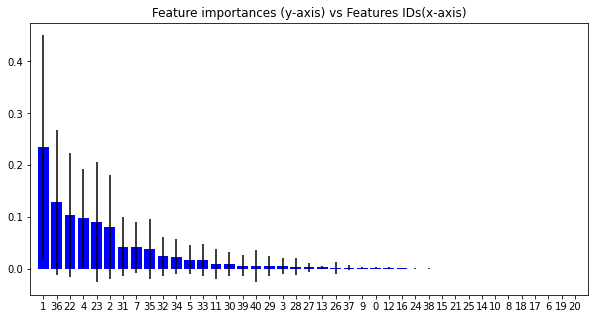

In [6]:
##### Function for features selection for the Model Training

def FeatureSelection(myinputX, myinputY):

    labels = np.array(myinputY).astype(int)
    inputX = np.array(myinputX)
    
    #Random Forest Model
    model = RandomForestClassifier(random_state = 0)
    model.fit(inputX,labels)
    importances = model.feature_importances_
    
    
    #Plotting the Features agains their importance scores
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    plt.figure(figsize = (10,5))
    plt.title("Feature importances (y-axis) vs Features IDs(x-axis)")
    plt.bar(range(inputX.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
    plt.xticks(range(inputX.shape[1]), indices)
    plt.xlim([-1, inputX.shape[1]])
    plt.show()
    
    # Selecting top featueres which have higher importance values = here we can find "12" features
    #as we can see in the next step
    newX = myinputX.iloc[:,model.feature_importances_.argsort()[::-1][:12]]
   # Converting the X dataframe into tensors
    myX = newX.to_numpy()
    myY = labels

    return myX,myY

## Visualise the data for feature selction
    

print ("Performing the Feature Selection on the train data set")
reduced_X,reduced_Y = FeatureSelection(data_X,data_Y)


# Step 3: Model Training and Validation

In [7]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import load_model

# Train features and Train Labels
train_X = reduced_X[:8000]
train_Y = reduced_Y[:8000]

#Test Features and Test Labels
test_X = reduced_X[8001:10000]
test_Y = reduced_Y[8001:10000]


print ("Train X shape is :", train_X.shape)
print ("Train Y shape is :", train_Y.shape)
print ("Test X shape is :", test_X.shape)
print ("Test Y shape is :", test_Y.shape)

## Normalizing the Input Features: Using tensorflow normalizing function

# Before normalizing, the array of input features should be converted to a dataframe
semitrain_X = pd.DataFrame(train_X)
semitest_X = pd.DataFrame(test_X)
#Importing Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Normalizing Train Data Features
scaler_traindata = scaler.fit(semitrain_X)
train_norm = scaler_traindata.transform(semitrain_X)
X_train=train_norm_X = pd.DataFrame(train_norm)

#Normalizing Test Data Features
scaler_testdata = scaler.fit(semitest_X)
test_norm = scaler_testdata.transform(semitest_X)
X_test=test_norm_X = pd.DataFrame(test_norm)
#Testing/Training Data
Y_train=train_Y
Y_test=test_Y
# Useful paprameters for the Autoencoder
 # dimension one one input data
input_dim = X_train.shape[1]
# this is the size of our encoded representations
encoding_dim = 32 
    
## For OMP error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(encoder)
encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)
code = Dense(int(encoding_dim-4), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim-2), activation='tanh')(code)
decoder = Dense(int(encoding_dim), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

## Parameters for Model configuration and saving 
nb_epoch = 100
batch_size = 60
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
                               
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history
                                                

autoencoder = load_model('model.h5')
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

Train X shape is : (8000, 12)
Train Y shape is : (8000, 2)
Test X shape is : (1999, 12)
Test Y shape is : (1999, 2)
Epoch 1/100
134/134 [==============================] - 1s 5ms/step - loss: 0.1002 - accuracy: 0.3922 - val_loss: 0.0132 - val_accuracy: 0.8834
Epoch 2/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.7199 - val_loss: 0.0133 - val_accuracy: 0.9365
Epoch 3/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.7438 - val_loss: 0.0333 - val_accuracy: 0.9655
Epoch 4/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.7856 - val_loss: 0.0245 - val_accuracy: 0.9605
Epoch 5/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.7873 - val_loss: 0.0227 - val_accuracy: 0.9650
Epoch 6/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.7892 - val_loss: 0.0222 - val_accuracy: 0.9595
Epoch 7/100
134/134 [=====